In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from sklearn.metrics import auc
from matplotlib.pyplot import cm

"""
This Jupyter Notebook is used for debugging purposes and is not recommended to be used for final plotting purposes due to the scaling of the legend.
"""


sensorDirectory = 'c:\\Users\\chris\\OneDrive\\Desktop\\Alphasim\\Data\\W14\\300V'
sensorFolder = []
pinSensorDirectory = 'c:\\Users\\chris\\OneDrive\\Desktop\\Alphasim\\Data\\W14_pin\\150V'
pinSensorFolder = []
sensorName = 'FBK Space Sensor W14 300V vs W14 Pin 150V Gain'
skip = 1 #How many files to skip to make data processing faster, Ex: skip = 1 increments by 1, meaning all data will be processed
pinSkip = 1
resistance = 470
lowerBound = -1
upperBound = 6
sdDiff = 3

os.chdir(sensorDirectory)
for x in os.listdir(): #Creates a list of the folder names in the sensor directory
    sensorFolder.append(x)

print(sensorFolder)

os.chdir(pinSensorDirectory)
for x in os.listdir(): #Creates a list of the folder names in the pin sensor directory
    pinSensorFolder.append(x)

print(pinSensorFolder)

['W14_300v_0deg', 'W14_300v_15deg', 'W14_300v_22deg', 'W14_300V_30deg', 'W14_300v_37deg', 'W14_300V_45deg']
['W14_pin_150V_Pin 0deg', 'W14_pin_150V_Pin 22deg', 'W14_pin_150V_Pin 45deg']


In [2]:
def getData(folder, directory, skip = skip, lowerBound = lowerBound, upperBound = upperBound): #Gets the data from an inputted folder
    """
    getData takes an input directory that has a list of folders within it and takes data from each of those folders in the directory.
    It takes an input skip that will determine how many files it will retrieve data from within each folder. Ex: skip = 1 means it will take data from each file,
    while skip = 2 means it will take data from every 2 files. From each file, it will extract the voltage and the corresponding time for the period -10 to 10 ns
    It will calculate the average voltage meanBaselineVoltage from the voltages within the period -10 to -1.5 ns and subtract that voltage from all of the voltages.
    Using this corrected voltage, the function will integrate voltage with respect to time to obtain charge (pC) within the time range of lowerBound to upperBound.
    Finally, it returns the list of charges calculated.
    """
    files = []
    os.chdir(directory)

    print('Getting data from: ' + folder)

    for x in os.listdir(folder): #Creates a list of the file names within the inputted folder that end with .csv
        if x.endswith('.csv'):
            files.append(x)
    
    os.chdir(folder)

    data = []
    if skip == 0:
        for i in range(0, len(files)): #Creates a list data of pandas dataframes containing the csv data for each file in the specified folder
            data.append(pd.read_csv(files[i], names = ('Time', 'Voltage')))
    else:
        for i in range(0, len(files), skip): #Creates a list data of pandas dataframes containing the csv data for each file in the specified folder with incremental skips
            data.append(pd.read_csv(files[i], names = ('Time', 'Voltage')))
    
    #print(data)
    #print(data[0]['Voltage'])

    #maxVoltages = []
    print('Calculating charge')
    charges = []
    for i in range(0, len(data)):
        time = data[i]['Time'] * 1e9 #Accessing time and voltage from the list data and converting to ns and mV respectively
        voltage = data[i]['Voltage'] * 1e3
        #print(data[i]['Time'])
        #print(time)
        
        baselineVoltage = []
        for j in range(len(time)):
            if(time[j] > -10 and time[j] < -1.5):
                baselineVoltage.append(voltage[j]) #Appends the voltages for times > 10 and < -1.5 ns to baselineVoltage
        
        meanBaselineVoltage = np.mean(baselineVoltage) #Calculates the average baseline voltage for each data frame in data
        correctedVoltage = voltage - meanBaselineVoltage #Corrects the voltage based off the average baseline voltage

        integrationTime = []
        integrationVoltage = []
        for j in range(len(time)):
            if(time[j] > lowerBound and time[j] < upperBound):
                integrationTime.append(time[j])
                integrationVoltage.append(correctedVoltage[j])
            else:
                continue
        
        #maxVoltage = np.max(correctedVoltage) #Finds the maximum corrected voltage
        #maxVoltages.append(maxVoltage)

        charge = auc(integrationTime, integrationVoltage)/resistance #Integrates the current I = V/R with respect to time
        charges.append(charge) #Appends the charge for each file to list charges
    
    return charges #Returns a list of charges for the files read

In [3]:
def gaussianFit(x, amplitude, mu, sigma):
    """
    gaussianFit defines the equation for the gaussian distribution so that it may be called by curve_fit.
    """
    y = amplitude * np.exp(-(x - mu)**2 / (2 * sigma**2)) #Defines the gaussian function to be used in the curve fitting
    return y

In [4]:
def fitCurve(charges, numBins):
    """
    fitCurve takes an input list charges and numBins to fit a gaussian distribution of the data charges for a numBins amount of bins.
    """
    frequencies, bins = np.histogram(charges, numBins) #Creates a numerical list of frequencies and their corresponding bins for the new charges
    nonZeroIndices = np.where(frequencies>0)[0] #Creates a list of the indices where there are non zero frequencies for a bin
    nonZeroFrequencies = frequencies[nonZeroIndices] #Creates list of non zero frequencies in the histogram and their corresponding bins
    nonZeroBins = bins[nonZeroIndices]
    gaussianFitParameters, gaussianFitUncertainties = sp.optimize.curve_fit(gaussianFit, nonZeroBins, nonZeroFrequencies) #Gathers the parameters and their uncertainties for a gaussian fit given the input bins and frequencies
    if(gaussianFitParameters[2] <= 0): #Takes the absolute value of uncertainty as curve_fit can return a negative value and break the code
        gaussianFitParameters[2] = abs(gaussianFitParameters[2])
    return gaussianFitParameters, nonZeroBins

In [5]:
colours = cm.rainbow(np.linspace(0,1,6)) #Colours to be used when plotting
def histogramPlot(folder, directory, numBins = 200, skip = skip, pinMeanDiff = 1, pinrmsDiff = 0, isPin = False): #Used for iterating over entire directory and the folders inside of it
    """
    histogramPlot takes an input directory and a list of folders within it to plot the gain of the sensor on a rainbow colour map scaling. 
    It uses numBins to calculate the histogram and gaussian fit. The function calls getData using the folder, directory, and skip to obtain charges.
    These charges and numBins are then used to call fitCurve to obtain a gaussian distribution of the raw data. Then, the function will calculate the upper and lower bounds
    within a certain standard deviation sdDiff range. It will trim all charges that do not fall within such range and then refit the gaussian distribution of the new data.
    From the trimmed charges, it will divide by the pin sensor's average charge pinMeanDiff and obtain a list of gains. Then, it fits the gaussian distribtuion of the resulting gain
    and propagates the error to obtain the gain's uncertainty. Finally, it plots a histogram of the gain as well as the gaussian distribution. 
    """
    for i in range(len(folder)): #Iterates over every folder in the directory
        charges = getData(folder[i], directory, skip, lowerBound, upperBound) #Gathers the charges from each folder in the directory
        print('First gaussian fit on charge')
        lgadGaussianFitParameters, nonZeroBins = fitCurve(charges, numBins) #Finds the gaussian fit parameters from the lgad charges
        sdAdd = lgadGaussianFitParameters[1] + (sdDiff * lgadGaussianFitParameters[2]) #Finds the minimum and maximum allowed values that will fit within the sdDiff sigma range
        sdSub = lgadGaussianFitParameters[1] - (sdDiff * lgadGaussianFitParameters[2])
        sdCharges = []
        print('Trimming data')
        for charge in charges:
            if sdSub <= charge and charge <= sdAdd:
                sdCharges.append(charge)
        print('Second gaussian fit on data')
        lgadGaussianFitParameters, nonZeroBins = fitCurve(sdCharges, numBins)
        
        print('Calculating gain')
        charges = [charge / pinMeanDiff for charge in sdCharges] #Divides meanDiff from each charge in charges to obtain gain
        plt.hist(x = charges, density = False, bins = numBins, color = colours[i], histtype= 'step') #Creates a histogram for the charges
        print('Plotting data from: ' + folder[i])
        gaussianFitParameters, nonZeroBins = fitCurve(charges, numBins) #Finds the gaussian fit parameters from the gain
        
        meanCharge = f'{gaussianFitParameters[1]:.5f}' #Truncates the mean charge and RMS
        meanChargeRMS = f'{gaussianFitParameters[1] * np.sqrt((pinrmsDiff / pinMeanDiff)**2 + (lgadGaussianFitParameters[2] / lgadGaussianFitParameters[1])**2):.5f}' #RMS = mean * sqrt[(pin RMS/pin mean)^2 + (LGAD RMS/LGAD mean)^2]
        fileLabel = folder[i][folder[i].rfind('_') + 1:] + ', mean = ' + meanCharge + ', rms = ' + meanChargeRMS + ', ' + str(len(charges)) + ' pulses' #Creates the label for the legend
        xFit = np.linspace(nonZeroBins[0], nonZeroBins[-1], 200) #Creates a linear space from the lowest to highest non zero frequency bin
        yFit = gaussianFit(xFit, *gaussianFitParameters) #Creates the gaussian fit for the parameters estimated by curve_fit
        
        if(isPin == True):
            plt.plot(xFit, yFit, lw = 2, color = colours[-i-2], label=fileLabel) #Plots the gaussian fit
        else:
            plt.plot(xFit, yFit, lw = 2, color = colours[i], label=fileLabel)
        #print(gaussianFitParameters, gaussianFitUncertainties)

In [6]:
def pinHistogramPlot(folder, directory, numBins = 200, skip = skip, combineFolders = True): #Used for combining folders and returning the mean and RMS
    """
    pinHistogramPlot does almost the same as histogramPlot except it combines the folders within the directory as the data for pin sensors does not change much
    for differing angles. However, pinHistogramPlot can be called with combineFolders = False which calls histogramPlot.
    """
    if(combineFolders == True):
        pinSensorCharges = []
        combinedPinSensorCharges = []
        print('Starting combined sensors')
        for i in range(len(folder)):
            pinSensorCharges.append(getData(folder[i], directory, skip, -1, 3))
        for i in pinSensorCharges:
            combinedPinSensorCharges += i
        
        #print('Plotting combined sensors')
        
        #plt.hist(x = combinedPinSensorCharges, density = False, bins = numBins, color = colours[-1], histtype= 'step') #Creates a histogram for the charges

        frequencies, bins = np.histogram(combinedPinSensorCharges, numBins) #Creates a numerical list of frequencies and their corresponding bins for the charges
        nonZeroIndices = np.where(frequencies>0)[0] #Creates a list of the indices where there are non zero frequencies for a bin
        nonZeroFrequencies = frequencies[nonZeroIndices] #Creates list of non zero frequencies in the histogram and their corresponding bins
        nonZeroBins = bins[nonZeroIndices]

        gaussianFitParameters, gaussianFitUncertainties = sp.optimize.curve_fit(gaussianFit, nonZeroBins, nonZeroFrequencies) #Gathers the parameters and their uncertainties for a gaussian fit given the input bins and frequencies
        meanCharge = f'{gaussianFitParameters[1]:.5f}' #Truncates the mean charge and RMS
        meanChargeRMS = f'{gaussianFitParameters[2]:.5f}'
        fileLabel = 'Combined, mean = ' + meanCharge + ', rms = ' + meanChargeRMS + ', ' + str(len(combinedPinSensorCharges)) + ' pulses' #Creates the label for the legend
        xFit = np.linspace(nonZeroBins[0], nonZeroBins[-1], 200) #Creates a linear space from the lowest to highest non zero frequency bin
        yFit = gaussianFit(xFit, *gaussianFitParameters) #Creates the gaussian fit for the parameters estimated by curve_fit
        #plt.plot(xFit, yFit, lw = 1, color = colours[-1], label=fileLabel) #Plots the gaussian fit
        return gaussianFitParameters[1], gaussianFitParameters[2] #Returns the mean and uncertainty respectively
    else:
        histogramPlot(folder, directory, numBins, skip, 1, 1, True)

Starting combined sensors
Getting data from: W14_pin_150V_Pin 0deg
Calculating charge
Getting data from: W14_pin_150V_Pin 22deg
Calculating charge
Getting data from: W14_pin_150V_Pin 45deg
Calculating charge
Getting data from: W14_300v_0deg
Calculating charge
First gaussian fit on charge
Trimming data
Second gaussian fit on data
Calculating gain
Plotting data from: W14_300v_0deg
Getting data from: W14_300v_15deg
Calculating charge
First gaussian fit on charge
Trimming data
Second gaussian fit on data
Calculating gain
Plotting data from: W14_300v_15deg
Getting data from: W14_300v_22deg
Calculating charge
First gaussian fit on charge
Trimming data
Second gaussian fit on data
Calculating gain
Plotting data from: W14_300v_22deg
Getting data from: W14_300V_30deg
Calculating charge
First gaussian fit on charge
Trimming data
Second gaussian fit on data
Calculating gain
Plotting data from: W14_300V_30deg
Getting data from: W14_300v_37deg
Calculating charge
First gaussian fit on charge
Trimming

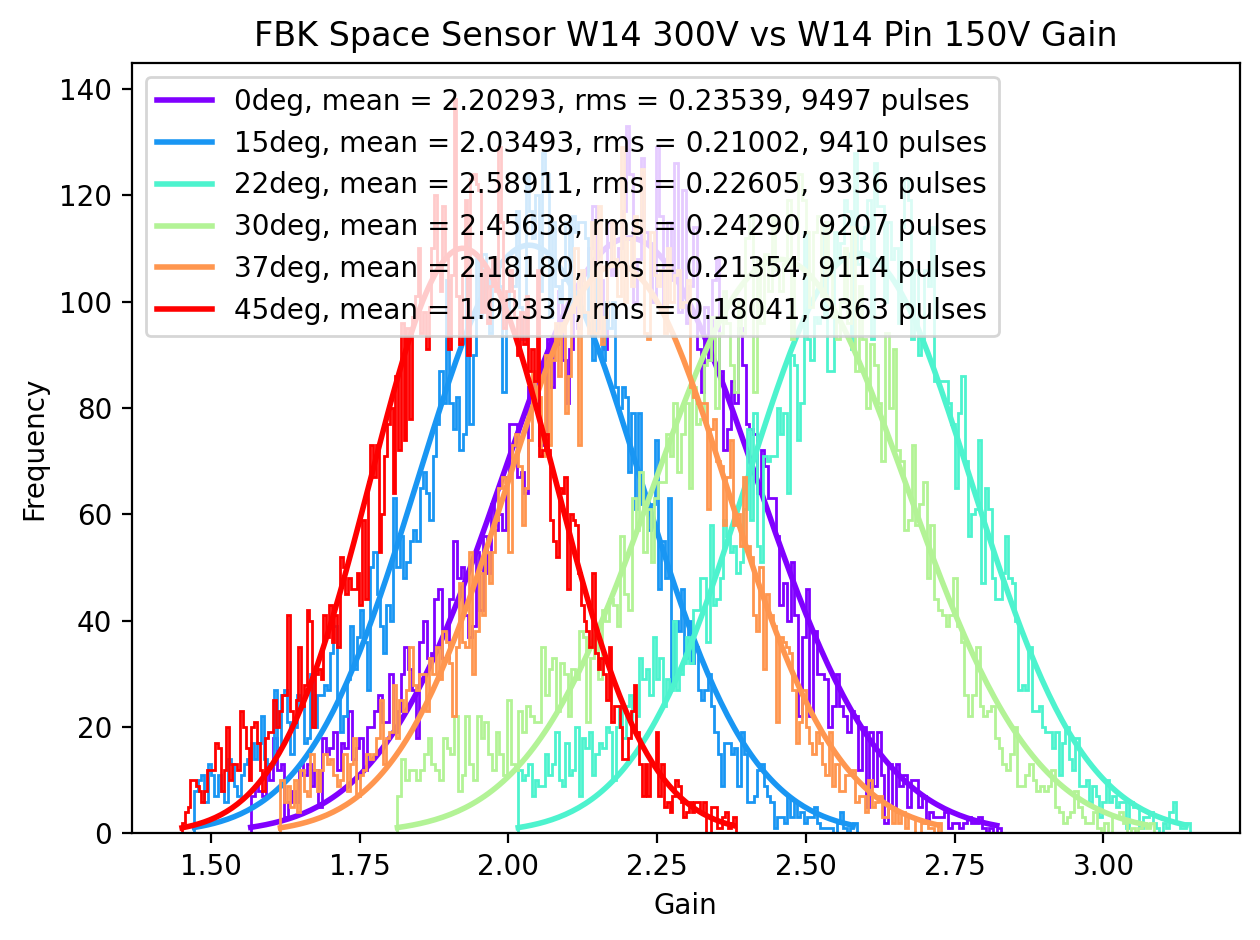

In [11]:
#pinHistogramPlot(pinSensorFolder, pinSensorDirectory, 200, pinSkip, False)
pinMeanDiff, pinrmsDiff = pinHistogramPlot(pinSensorFolder, pinSensorDirectory, 200, skip, True)
#lgadMeanDiff, lgadrmsDiff = getLGADGaussianParameters(sensorFolder, sensorDirectory, 200, skip)
#histogramPlot(sensorFolder, sensorDirectory, 200, skip)
histogramPlot(sensorFolder, sensorDirectory, 200, skip, pinMeanDiff, pinrmsDiff)
plt.title(sensorName)
plt.xlabel('Gain')
plt.ylabel('Frequency')
plt.legend(loc = 'upper left', fontsize =  10)
#plt.savefig(sensorDirectory + '\\' + sensorName)
plt.tight_layout()
plt.rcParams['figure.figsize'] = [17, 10]
plt.rcParams['figure.dpi'] = 100
plt.show()